## Lecture 4 - MIR for non-Western music traditions - 3
### Tuning analysis for a single recording

This notebook was written for the tutorial offered at the 19th ISMIR Conference in Paris, France, on September 23rd, 2018 titled ["Computational Approaches for Analysis of Non-Western Music Traditions"](https://www.upf.edu/web/mtg/non-western-music-tutorial).

Here, we demonstrate tuning analysis of a single recording in makam Huseyni (a commonly used makam with a scale close to western A dorian with a characteristic second tone lower in pitch (resulting in two microtonal intervals around it)). The following steps are carried:
- We first download a specific recording: https://musicbrainz.org/recording/9d195cbe-8e9f-47ef-83f0-e7c0b8af1697, Dunya direct-link: 
http://dunya.compmusic.upf.edu/makam/recording/9d195cbe-8e9f-47ef-83f0-e7c0b8af1697 .It includes automatically alligned scores. You can first listen to the recording through Dunya.
- Then pitch analysis and pitch distribution computation is carried
- Tonic annotation is accessed from Dunya and further interval distributions are computed (with respect to tonic)
- Octave folding and automatic peak picking applied to detect scale degrees' distance to the tonic
- Interval list stored in the Scala format (http://www.huygens-fokker.org/scala/) to be able to sonify the intervals using computer keyboard

To be able to download sounds from Dunya, you would need to create a user and obtain an API authenticaion key(token). Please create your user from: https://dunya.compmusic.upf.edu/developers/ In order to get your API token you have to log in to Dunya, access your profile, you will find your token there. 

In [1]:
# Set your token here from https://dunya.compmusic.upf.edu/user/profile/
token = '...yourAPITokenGoesHere...'

In [2]:
import os 
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from compmusic.dunya import docserver as ds
from compmusic import dunya as dn
from essentia.standard import *
from external_utilities.pitchdistribution import PitchDistribution

from compmusic import dunya
dn.set_token(token)

%matplotlib inline
CENTS_IN_OCTAVE = 1200
REF_PITCH = 220

### Downloading the recording

Execute **one** of the following cells to configure the data for the example

In [3]:
#sample for makam Huseyni
mbid = '9d195cbe-8e9f-47ef-83f0-e7c0b8af1697'
mode = 'Huseyni'

In [4]:
#sample for makam Saba
#mbid = '2a424528-5cbd-412b-936f-6a4d0da3bdeb'
#mode = 'Saba'

In [5]:
#sample for makam Rast
#mbid = '10b18a18-7ea6-4fdd-bb39-ee1528b4e31b'
#mode = 'Rast'

Now we download the MP3 file defined in one of the previous cells

In [6]:
dataDir = os.path.join('..', 'data', 'compMusicDatasets', 'turkishMakam', mode)
os.makedirs(dataDir, exist_ok = True)

mp3_filename = os.path.join(dataDir, '{}.mp3'.format(mbid))

# Download file if it has not been previously downloaded
if not os.path.exists(mp3_filename):
    contents = ds.file_for_document(mbid, 'mp3')
    with open(mp3_filename, 'wb') as fp:
        fp.write(contents)
    print('File downloaded: {}'.format(mp3_filename))
else:
    print('File already exists, skipping download')

File already exists, skipping download


### Pitch extraction and distribution computation

In [7]:
# Setting file names for writing analysis results
pitchFile = os.path.join(dataDir, '{}.pitch'.format(mbid))
histFile = os.path.join(dataDir, '{}.pitch_hist.json'.format(mbid))

#Reading tonic annotation for the recording from Dunya
content = ds.file_for_document(mbid, 'audioanalysis', 'tonic')
content = json.loads(content.decode())
tonic_hz = content['value']
print('Tonic read from Dunya server: {} Hz'.format(round(tonic_hz, 2)))

def compute_pitch(filename):
    #Running Pitch Melodia with default parameters
    fs = 44100
    run_predominant_melody = PitchMelodia(sampleRate = fs)
    x = MonoLoader(filename = filename, sampleRate = fs)()
    x = EqualLoudness()(x)
    f0, confidence = run_predominant_melody(x)
    return f0, run_predominant_melody.paramValue('hopSize'), fs

# If pitch file exists, read it, if not run extractor and create the pitch file
if not os.path.exists(pitchFile):
    print("Computing pitch, writing output to file")
    pitchSeriesHz, hopSize, fs = compute_pitch(mp3_filename)
    # you can use the pitch file together with SonicVisualizer to view in sync with the spectrogram of the mp3 file
    windowIndex = 0
    with open(pitchFile, 'w') as fp:
        for pitchHz in pitchSeriesHz:
            #writing timeStamp and pitch value on each row
            fp.write("{0:3.3f}\t{1:3.3f}\n".format(windowIndex * hopSize / fs, pitchHz))
            windowIndex +=1
else:
    print("Pitch files exists, reading from it")
    pitchData = np.loadtxt(pitchFile)
    timeStamps = pitchData[:,0]
    pitchSeriesHz = pitchData[:,1]

Tonic read from Dunya server: 221.91 Hz
Pitch files exists, reading from it


In [8]:
#Pitch distribution computation
#pitch distribution extractor parameters in cents
pd_params = {'kernel_width': 5, 'step_size': 5}
#Optional, the following values can also be tested: 1,2.5,7.5

# Computing pitch distribution with default reference frequency = REF_PITCH
pitch_distribution = PitchDistribution.from_hz_pitch(pitchSeriesHz, REF_PITCH, **pd_params)
pitch_distribution.to_json(histFile)

# Computing pitch distribution with reference frequency = tonic
pitch_distribution_tonicRef = PitchDistribution.from_hz_pitch(pitchSeriesHz, tonic_hz, **pd_params)
hist_file_wrt_tonic = os.path.join(dataDir, '{}.pitch_hist_wrtTonic.json'.format(mbid))
pitch_distribution_tonicRef.to_json(hist_file_wrt_tonic)
print('Pitch and pitch distribution files created')

Pitch and pitch distribution files created


In [12]:
# Function definition for automatic scale-interval detection from pitch distribution
def peakLocationDetection(pcd):
    '''A simple peak detection implementation for demonstration purposes
    Thresholds are manually set for this demo
    '''
    windowSize = 9  # should be odd
    midPointIndex = int(windowSize / 2)
    threshold = np.max(pcd) * 0.1
    peakIndexes = []
    for index in range(len(pcd) - windowSize):
        frame = pcd[index:index + windowSize]
        if np.argmax(frame) == midPointIndex and np.max(frame) > threshold:
            peakIndexes.append(index + midPointIndex)
    return peakIndexes


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


Intervals computed: [ 155  295  495  710  795  885 1005] (cents with respect to tonic)


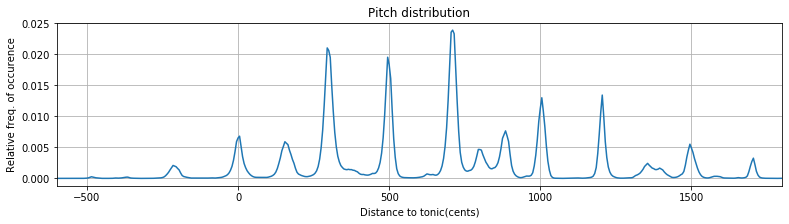

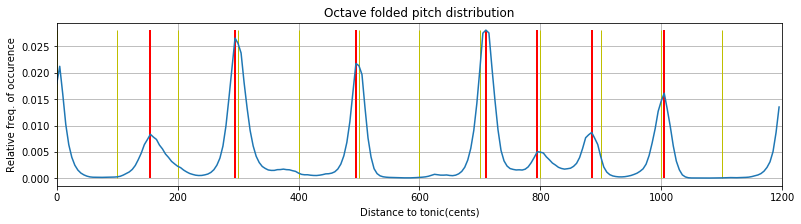

In [13]:
# Creating octave folded distribution
bins = np.linspace(0, CENTS_IN_OCTAVE, CENTS_IN_OCTAVE / pd_params['step_size'], endpoint = False)
# pitch class distribution
pcd = np.zeros_like(bins)
for bin_pd, val in zip(pitch_distribution_tonicRef.bins, pitch_distribution_tonicRef.vals):
    # corresponding index in pitch class distribution
    index_pcd = int(np.mod(bin_pd, CENTS_IN_OCTAVE) / pd_params['step_size'])
    pcd[index_pcd] += val

plt.figure(figsize = (13, 3))
plt.title('Pitch distribution')
plt.plot(pitch_distribution_tonicRef.bins, pitch_distribution_tonicRef.vals)
plt.grid()
plt.xlim([-600, 1800])
plt.ylabel('Relative freq. of occurence')
plt.xlabel('Distance to tonic(cents)')

plt.figure(figsize=(13, 3))
plt.title('Octave folded pitch distribution')
plt.plot(bins, pcd)
plt.xlim([0,1200])
plt.grid()
ticks = np.arange(0, 1200, 100)
plt.vlines(ticks, 0, max(pcd), color='y', lw=1)
plt.ylabel('Relative freq. of occurence')
plt.xlabel('Distance to tonic(cents)')

#Detect intervals from pitch distribution and plot them on the figure
intervals = np.array(peakLocationDetection(pcd)) * pd_params['step_size']
plt.vlines(intervals, 0, max(pcd), color='r', lw=2)
print('Intervals computed: {} (cents with respect to tonic)'.format(intervals))

### Creating the Scala file
Writing the scale to .scl file which can be loaded in Scala with which one can sonify the estimated scale 

In [14]:
scalaFile = os.path.join(dataDir, '{}.scl'.format(mbid))
with open(scalaFile, 'w') as fp:
    fp.write('! autopeak.scl\n!\nFile created by tuningAnalysis\n'+str(len(intervals)+1)+'\n!\n')

    #First octave
    for interval in intervals:
        fp.write(str(float(interval)) + '\n')
    fp.write(str(float(CENTS_IN_OCTAVE)) + '\n')#octave
    fp.close()

### Loading the estimated scale in Scala
Initiate a synthesizer your Scala software can communicate with for synthesis (for example simplesynth). Open Scala and click 'Open' to choose the .scl file this code has created in your local folder: 9d195cbe-8e9f-47ef-83f0-e7c0b8af1697.scl

Scala would display the set of pitches of the loaded scale as a list. Click 'Opts.' on the top menu to set reference tuning frequency and note-name. Huseyni makam's tonic is represented with A in Western scale. So, set i) the tonic frequency('frequency for 1/1') as printed above: 221.9144 and ii) offset as A.0 (deafult is C.0)

Now you can click 'Play' on the top menu to start experiment with your new keyboard playing Huseyni scale automatically extracted by the analysis above. Enjoy!